In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
%matplotlib inline
## %matplotlib inline --> very cool: can show more than one graphs in same plot
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [2]:
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
# creating a cte where the count of rentals will be shown and then joining it with the rental table to add a column containing all rental dated for each film

query = '''with cte_predict_rentals as (
    select f.film_id, f.title, f.release_year, f.language_id, f.original_language_id, f.length, f.rating, c.category_id, count(r.rental_id) as num_rentals from film f
    left join film_category c
    using (film_id)
    join inventory i
    using (film_id)
    join rental r
    using (inventory_id)
    group by f.film_id, f.title, f.release_year, f.language_id, f.original_language_id, f.length, f.rating, c.category_id)
select p.*, date(r.rental_date) as rental_date from cte_predict_rentals p
right join inventory i
using (film_id)
join rental r
using (inventory_id);'''

In [4]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,release_year,language_id,original_language_id,length,rating,category_id,num_rentals,rental_date
0,1,ACADEMY DINOSAUR,2006,1,None,86,PG,6,23,2005-07-08
1,1,ACADEMY DINOSAUR,2006,1,None,86,PG,6,23,2005-08-02
2,1,ACADEMY DINOSAUR,2006,1,None,86,PG,6,23,2005-08-21
3,1,ACADEMY DINOSAUR,2006,1,None,86,PG,6,23,2005-05-30
4,1,ACADEMY DINOSAUR,2006,1,None,86,PG,6,23,2005-06-17


### Exploring the data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16045 entries, 0 to 16044
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   film_id               16045 non-null  int64 
 1   title                 16045 non-null  object
 2   release_year          16045 non-null  int64 
 3   language_id           16045 non-null  int64 
 4   original_language_id  0 non-null      object
 5   length                16045 non-null  int64 
 6   rating                16045 non-null  object
 7   category_id           16045 non-null  int64 
 8   num_rentals           16045 non-null  int64 
 9   rental_date           16045 non-null  object
dtypes: int64(6), object(4)
memory usage: 1.2+ MB


In [6]:
data['language_id'].nunique() # only one value

1

In [7]:
data['release_year'].nunique() # doesn't give us any information to work with

1

#### Notes:
- there are no NaNs apart from all the values of original_language_id
- language_id, original_language_id and release_year will have to be dropped
- rating will have to be encoded (later along the process)
- rental_date will have to be turned into data type datetime

### Cleaning the data

In [8]:
data = data.drop(['language_id', 'release_year', 'original_language_id'], axis = 1)
data

,film_id,title,length,rating,category_id,num_rentals,rental_date
0,1,ACADEMY DINOSAUR,86,PG,6,23,2005-07-08
1,1,ACADEMY DINOSAUR,86,PG,6,23,2005-08-02
2,1,ACADEMY DINOSAUR,86,PG,6,23,2005-08-21
3,1,ACADEMY DINOSAUR,86,PG,6,23,2005-05-30
4,1,ACADEMY DINOSAUR,86,PG,6,23,2005-06-17
...,...,...,...,...,...,...,...
16040,1000,ZORRO ARK,50,NC-17,5,32,2005-06-15
16041,1000,ZORRO ARK,50,NC-17,5,32,2005-07-12
16042,1000,ZORRO ARK,50,NC-17,5,32,2005-07-31
16043,1000,ZORRO ARK,50,NC-17,5,32,2005-08-19


In [9]:
data['rental_date'] = data['rental_date'].apply(lambda x : str(x))
data['rental_date'] = data['rental_date'].str.replace('-', '')


In [10]:
data['rental_date'] = pd.to_datetime(data['rental_date'].astype(str), format='%Y%m%d')
data['rental_date']

0       2005-07-08
1       2005-08-02
2       2005-08-21
3       2005-05-30
4       2005-06-17
           ...    
16040   2005-06-15
16041   2005-07-12
16042   2005-07-31
16043   2005-08-19
16044   2023-02-27
Name: rental_date, Length: 16045, dtype: datetime64[ns]

In [11]:
data['rating'].unique()

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

### Going further I will have to use a new query to essentialy create a new dataframe to use for my model, where each film will only take one row. I will encode rating after I create the new df
### In this case, i will not include the columns that I had to drop earlier
#### *Note: to create the new df, I decided to create columns containing info about whether or not a film has been rented (booleans) for all the respective months with rentals in record. I created those columns on mysql and will finish working on them here. Please refer to 'added_cols_updated_tables' for the specifics.*

In [12]:
# query to get last month's rentals and rentals on other months in record, regardless of year

query1 = '''select f.film_id,
f.title,
f.rating,
f.length,
c.category_id,
sum(r.rented_last_month) as last_month,
sum(r.rented_feb) as february,
sum(r.rented_may) as may,
sum(r.rented_june) as june,
sum(r.rented_july) as july,
sum(r.rented_aug) as august,
count(r.rental_id) as num_rentals
from film f
	join film_category c
		using (film_id)
	join inventory i
		using (film_id)
	join rental r
		using (inventory_id)
group by
f.film_id,
f.title,
f.rating,
f.length,
c.category_id
order by film_id asc;'''

In [13]:
data1 = pd.read_sql_query(query1, engine)
data1

,film_id,title,rating,length,category_id,last_month,february,may,june,july,august,num_rentals
0,1,ACADEMY DINOSAUR,PG,86,6,0.0,0.0,2.0,3.0,9.0,9.0,23
1,2,ACE GOLDFINGER,G,48,11,1.0,1.0,0.0,0.0,2.0,4.0,7
2,3,ADAPTATION HOLES,NC-17,50,6,0.0,0.0,1.0,1.0,4.0,6.0,12
3,4,AFFAIR PREJUDICE,G,117,11,1.0,1.0,2.0,2.0,12.0,6.0,23
4,5,AFRICAN EGG,G,130,8,1.0,1.0,1.0,2.0,5.0,3.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
953,996,YOUNG LANGUAGE,G,183,6,0.0,0.0,0.0,1.0,3.0,3.0,7
954,997,YOUTH KICK,NC-17,179,12,0.0,0.0,0.0,1.0,2.0,3.0,6
955,998,ZHIVAGO CORE,NC-17,105,11,1.0,1.0,1.0,2.0,3.0,2.0,9
956,999,ZOOLANDER FICTION,R,101,3,0.0,0.0,1.0,2.0,7.0,7.0,17


### Data exploration

In [14]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   film_id      958 non-null    int64  
 1   title        958 non-null    object 
 2   rating       958 non-null    object 
 3   length       958 non-null    int64  
 4   category_id  958 non-null    int64  
 5   last_month   958 non-null    float64
 6   february     958 non-null    float64
 7   may          958 non-null    float64
 8   june         958 non-null    float64
 9   july         958 non-null    float64
 10  august       958 non-null    float64
 11  num_rentals  958 non-null    int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 89.9+ KB


No need for cleaning

In [15]:
specs = data1[['film_id', 'title']] # keeping the title and film_id of the films separately, in case they are useful later
data1 = data1.drop(['film_id', 'title'], axis = 1)


### EDA

In [16]:
num = data1.select_dtypes(include = np.number)
cat = data1.select_dtypes(include = object)

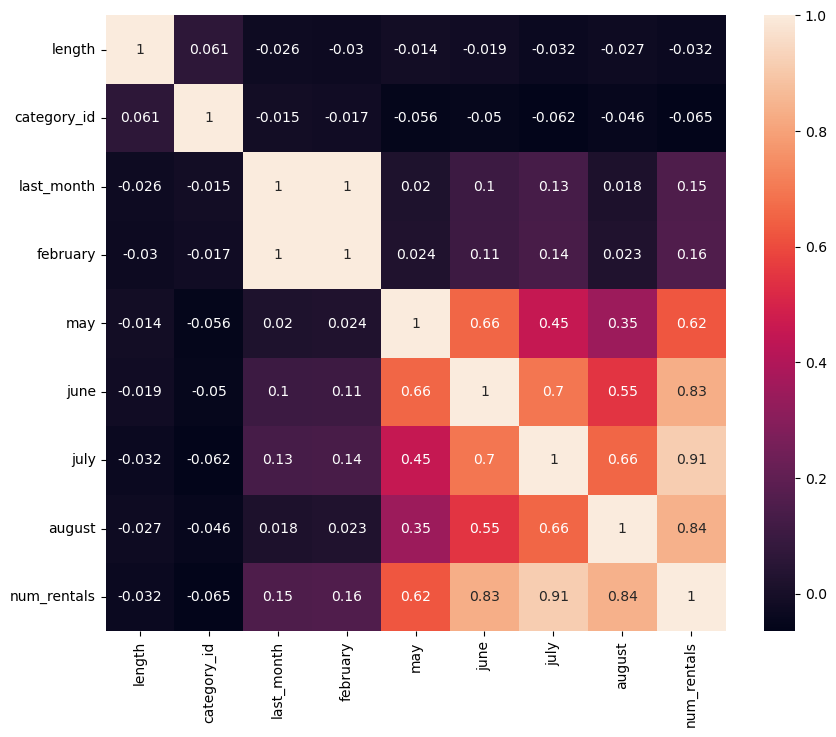

In [17]:
corr_matrix=data1.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#### The last month was February. What the correlation Matrix tells us is that all or the crushing majority of records of February were created last month. The column february will be dropped since it is redundant

In [18]:
# before that, I will check to see if I am right in my assumption

query2 = '''select rental_id from rental
where month(rental_date) = 02 and year(rental_date) <> 2006;'''

test_it = pd.read_sql_query(query2, engine)
test_it

,rental_id
0,16050


In [19]:
query3 = '''select rental_id from rental
where month(rental_date) = 02 and year(rental_date) = 2006;'''

test_it1 = pd.read_sql_query(query3, engine)
test_it1

,rental_id
0,13421
1,15542
2,15458
3,15294
4,12988
...,...
177,13486
178,15966
179,11676
180,14616


In [20]:
# only one record from February in any other than the last year, which shows me that a correlation of scale 1 can definitely be expected with 182 entries for February in the rental table

num = num.drop('february', axis = 1)

c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


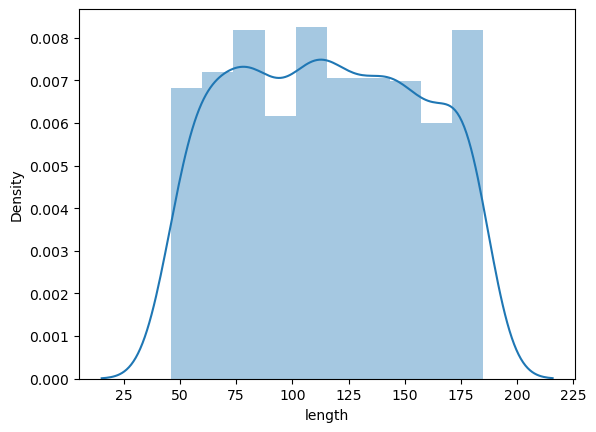

In [21]:
sns.distplot(num['length'])
plt.show()

c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


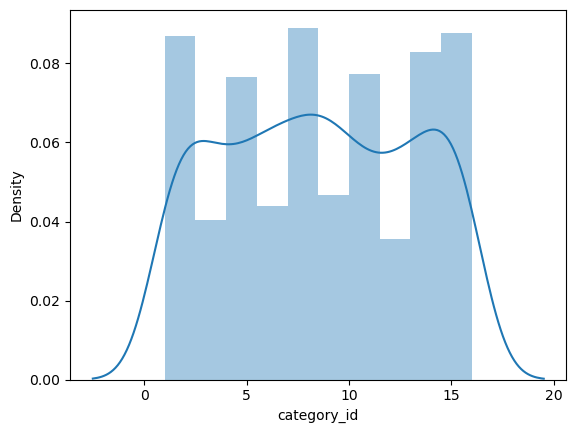

In [22]:
sns.distplot(num['category_id'])
plt.show()

c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


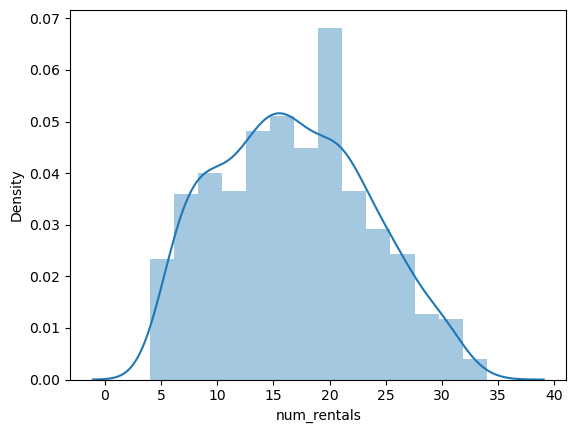

In [23]:
sns.distplot(num['num_rentals'])
plt.show()

c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


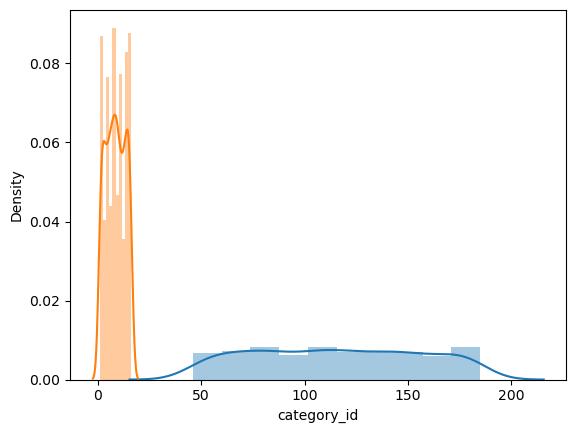

In [24]:
sns.distplot(num['length'])
sns.distplot(num['category_id'])


plt.show()

c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


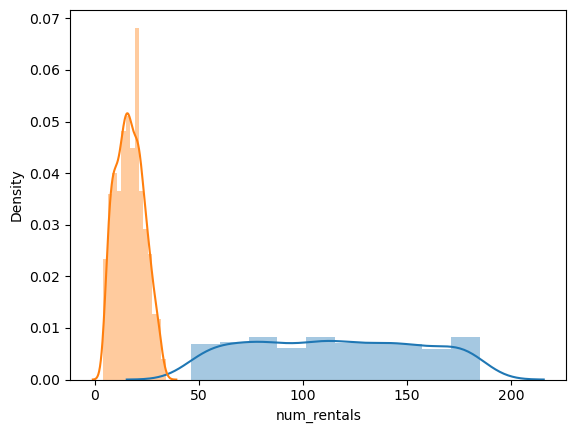

In [25]:
sns.distplot(num['length'])
sns.distplot(num['num_rentals'])

plt.show()

c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\vagli\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


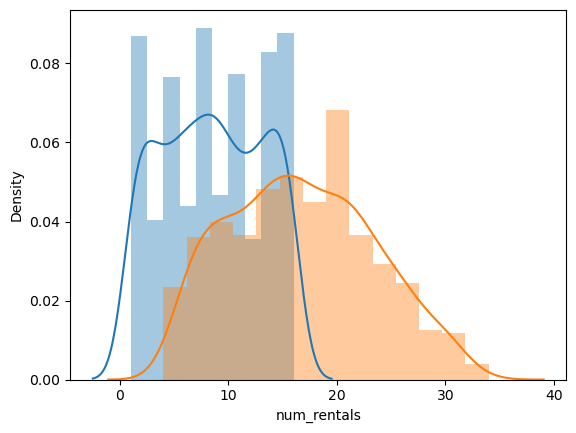

In [26]:
sns.distplot(num['category_id'])
sns.distplot(num['num_rentals'])

plt.show()

#### **The columns last_month, may, june, july, august contain the number of rentals from the last month and any may, june, july, august in record. I have used aggregation functions on sql to group them together, so that each film would appear only once in the table. At the moment they give us info in regards to the number of records per film.**
##### **The question to be answered is not how many times a film was rented, but rather whether it will be rented. For that reason, data that refer to rentals for each month will have to be changed to dummy values representing booleans**

In [27]:
def month_bool(x):
    if x > 0:
        return 1
    else:
        return 0

num['last_month'] = list(map(month_bool, num['last_month']))
num['may'] = list(map(month_bool, num['may']))
num['june'] = list(map(month_bool, num['june']))
num['july'] = list(map(month_bool, num['july']))
num['august'] = list(map(month_bool, num['august']))

In [28]:
num

,length,category_id,last_month,may,june,july,august,num_rentals
0,86,6,0,1,1,1,1,23
1,48,11,1,0,0,1,1,7
2,50,6,0,1,1,1,1,12
3,117,11,1,1,1,1,1,23
4,130,8,1,1,1,1,1,12
...,...,...,...,...,...,...,...,...
953,183,6,0,0,1,1,1,7
954,179,12,0,0,1,1,1,6
955,105,11,1,1,1,1,1,9
956,101,3,0,1,1,1,1,17


If I had to create a linear regression model, I would of course try to normalise the features length and number of rentals. In this case however, I will leave them be to see whether the accuracy of the model will be affected negatively

#### And now to encode the categoricals variables

In [29]:
cat_enc = pd.get_dummies(cat, columns=['rating'])

In [30]:
cat_enc = cat_enc.reset_index()

In [31]:
cat_enc

,index,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,0,1,0,0
1,1,1,0,0,0,0
2,2,0,1,0,0,0
3,3,1,0,0,0,0
4,4,1,0,0,0,0
...,...,...,...,...,...,...
953,953,1,0,0,0,0
954,954,0,1,0,0,0
955,955,0,1,0,0,0
956,956,0,0,0,0,1


In [32]:
# although category_id has numerical values, it is essentially a categorical variable. Thus, I will also encode it.

num_enc = pd.get_dummies(num, columns=['category_id'])

In [33]:
num_enc = num_enc.reset_index()
num_enc

,index,length,last_month,may,june,july,august,num_rentals,category_id_1,category_id_2,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0,86,0,1,1,1,1,23,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,48,1,0,0,1,1,7,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,50,0,1,1,1,1,12,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,117,1,1,1,1,1,23,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,130,1,1,1,1,1,12,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,953,183,0,0,1,1,1,7,0,0,...,0,0,0,0,0,0,0,0,0,0
954,954,179,0,0,1,1,1,6,0,0,...,0,0,0,0,0,1,0,0,0,0
955,955,105,1,1,1,1,1,9,0,0,...,0,0,0,0,1,0,0,0,0,0
956,956,101,0,1,1,1,1,17,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
to_model = num_enc.merge(cat_enc, on = 'index')
to_model = to_model.drop('index', axis = 1)
to_model

,length,last_month,may,june,july,august,num_rentals,category_id_1,category_id_2,category_id_3,...,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,86,0,1,1,1,1,23,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,48,1,0,0,1,1,7,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,50,0,1,1,1,1,12,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,117,1,1,1,1,1,23,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,130,1,1,1,1,1,12,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,183,0,0,1,1,1,7,0,0,0,...,0,0,0,0,0,1,0,0,0,0
954,179,0,0,1,1,1,6,0,0,0,...,1,0,0,0,0,0,1,0,0,0
955,105,1,1,1,1,1,9,0,0,0,...,0,0,0,0,0,0,1,0,0,0
956,101,0,1,1,1,1,17,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Train-test split

In [35]:
y = num['last_month']
X = to_model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [37]:
print("length of X_train:", len(X_train))
print("length of y_train:", len(y_train))

length of X_train: 718
length of y_train: 718


In [38]:
print("length of X_train:", len(X_test))
print("length of y_train:", len(y_test))

length of X_train: 240
length of y_train: 240


In [39]:
# training the model (logistic regression)
classify = LogisticRegression(random_state=0, multi_class='multinomial').fit(X_train, y_train)

c:\Users\vagli\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
predictions = classify.predict(X_test)

#### Time to run some tests to see how well the model performs

In [41]:
pd.Series(predictions).value_counts()

0    201
1     39
dtype: int64

In [42]:
y_test.value_counts()

0    201
1     39
Name: last_month, dtype: int64

In [43]:
confusion_matrix(y_test, predictions)

array([[201,   0],
       [  0,  39]], dtype=int64)

<AxesSubplot:>

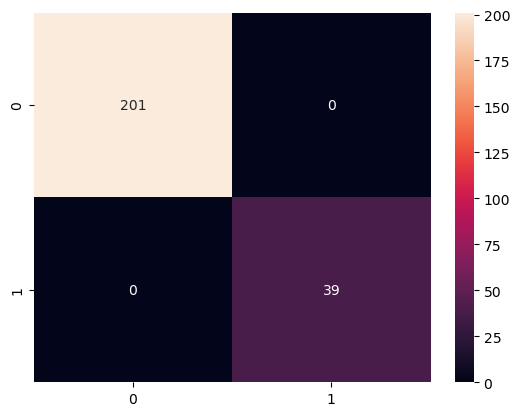

In [44]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True,fmt='g')

<AxesSubplot:>

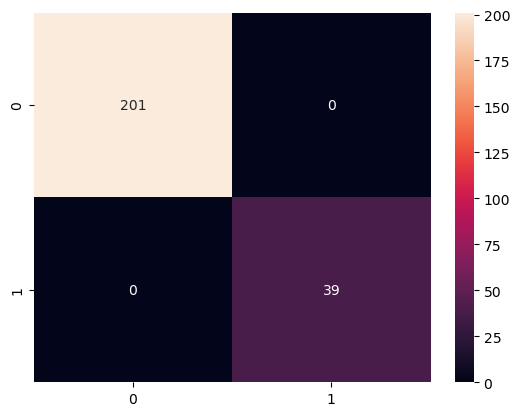

In [45]:
cm1 = confusion_matrix(predictions,y_test)
sns.heatmap(cm1, annot=True,fmt='g')

#### *Where 0 = chances the film won't be rented and 1 = chances it will be rented
### According to the confusion matrix we should expect the model to make no mistakes

### Testing the accuracy of the model

In [46]:
classify.score(X_test, y_test)

1.0

In [47]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predictions)))


Accuracy: 1.00



## This proves my previous assumption, but is also concerning in that the model might be overfitted